# Video stream processing

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import lanetracker as lt

In [2]:
# All the data 
with open("./camera_cal/calibration_data.p",'rb') as cal_f:
    calibration_data = pickle.load(cal_f) 
mtx = calibration_data['mtx']
dist = calibration_data['dist']

In [3]:
# Paramaters for transformation and perspective transform
sobelxparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'x',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}
sobelyparams = {
    'type': 'sobel',
    'channel': 'gray',
    'mode': 'y',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}
colorparams = {
    'type': 'color',
    'channel': 's',
    'low_thresh': 150,
    'high_thresh': 255
}
filter_params = [sobelxparams, sobelyparams, colorparams]
imshape = (720, 1280, 3)

def comb_function(imgs):
    combi = imgs[0]
    combi[((imgs[1] == 1) & (imgs[2] == 1)) | (imgs[3] == 1)] = 1
    return combi

# Parameters for lane finding
trap_topwidth=0.085
trap_bottomwidth=.6
trap_height=.37 
warp_width=.5 
bottom_offset=.08
nframes=10 
nwindows=9
minpix=50
width=80
window_margin=25
prior_margin=100
xmp=3.6/640
ymp=30/720

In [4]:
proc = lt.Processor(mtx, dist, filter_params, comb_function, trap_topwidth=trap_topwidth, 
                    trap_bottomwidth=trap_bottomwidth, trap_height=trap_height, warp_width=warp_width,
                   bottom_offset=bottom_offset, nframes=nframes, nwindows=nwindows, minpix=minpix, width=width,
                   window_margin=window_margin, prior_margin=prior_margin, xmp=xmp, ymp=ymp)
video_output = './output_videos/video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(proc.process_frame)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/video_output.mp4
[MoviePy] Writing video ./output_videos/video_output.mp4


100%|█████████▉| 1260/1261 [04:47<00:00,  4.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/video_output.mp4 

CPU times: user 2min 2s, sys: 30.4 s, total: 2min 33s
Wall time: 4min 50s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

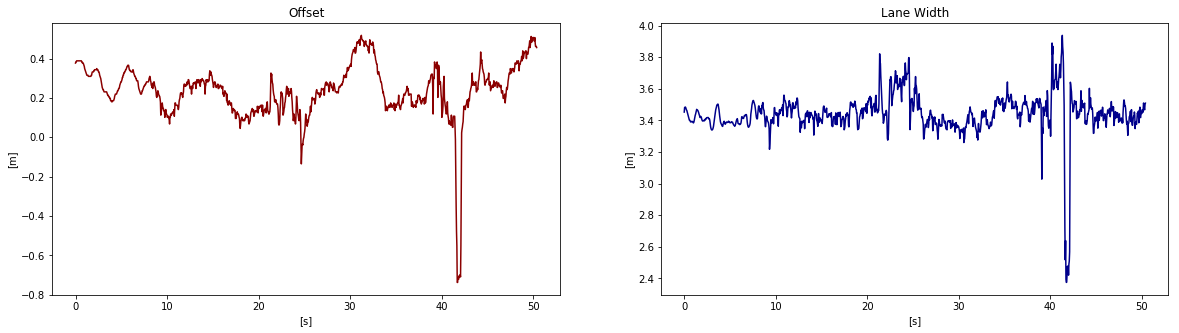

In [6]:
# Offset and lane width
f, ax = plt.subplots(1,2,figsize=(20,5))
t = np.arange(proc.right_line.tframe) / (1250/50)
ax[0].plot(t, proc.offset, c='darkred')
ax[1].plot(t, proc.lane_width, c='darkblue')
ax[0].set_title("Offset")
ax[1].set_title("Lane Width")
ax[0].set_xlabel("[s]")
ax[1].set_xlabel("[s]")
ax[0].set_ylabel("[m]")
ax[1].set_ylabel("[m]")
plt.show()

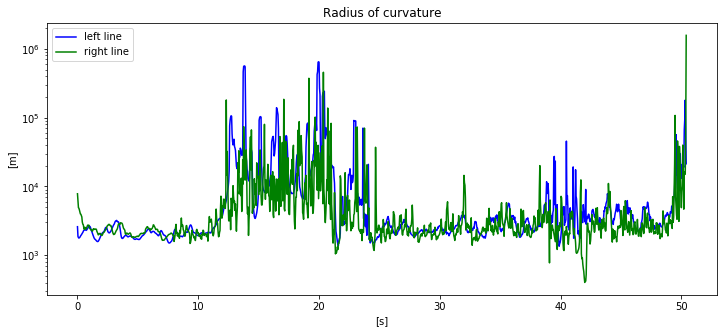

In [7]:
# Radius of curvature
f, ax = plt.subplots(1,1, figsize=(12,5))
ax.semilogy(t, proc.left_line.curvature, c='b')
ax.semilogy(t, proc.right_line.curvature, c='g')
ax.legend(['left line', 'right line'])
ax.set_title("Radius of curvature")
ax.set_ylabel("[m]")
ax.set_xlabel("[s]")
plt.savefig("")
plt.show()